<a href="https://colab.research.google.com/github/dsogden/Molecular_Embedings/blob/main/Solubility_Preds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def read_file(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

path = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
qm = read_file(path)
print(qm.head(5))

def build_vocab(smiles: np.ndarray) -> list:
    vocab = set(char for smile in smiles for char in smile)
    return sorted(list(vocab))

def get_length(smiles: np.ndarray) -> int:
    return max(len(smile) for smile in smiles)

# def vectorize(smiles: np.ndarray, vocab: list, max_length: int) -> tuple:
#     N = smiles.shape[0]
#     vectors = np.zeros((N, max_length + 2), dtype=np.int32)
#     encoder = {char: idx + 3 for idx, char in enumerate(vocab)}
#     encoder['<SOS>'] = 0
#     encoder['<EOS>'] = 1
#     encoder['<PAD>'] = 2
#     decoder = {idx: char for char, idx in encoder.items()}
#     for i, smile in enumerate(smiles):
#         vectors[i, 0] = encoder['<SOS>']
#         for j, char in enumerate(smile):
#             vectors[i, j + 1] = encoder[char]
#         vectors[i, j + 2] = encoder['<EOS>']
#         vectors[i, j + 3:] = encoder['<PAD>']
#     return vectors, encoder, decoder

# vocab = build_vocab(df.smiles.values)
# max_length = get_length(df.smiles.values)
# vectors, encoder, decoder = vectorize(df.smiles, vocab, max_length)

cuda:0
  mol_id smiles          A           B           C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3  gdb_4    C#C    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4  gdb_5    C#N    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   

     lumo     gap  ...      zpve         u0       u298       h298       g298  \
0  0.1171  0.5048  ...  0.044749 -40.478930 -40.476062 -40.475117 -40.498597   
1  0.0829  0.3399  ...  0.034358 -56.525887 -56.523026 -56.522082 -56.544961   
2  0.0687  0.3615  ...  0.021375 -76.404702 -76.401867 -76.400922 -76.422349   
3  0.0506  0.3351  ...  0.026841 -77.308427 -77.305527 -77.304583 -77.327429   
4  0.0191  0.3796  ...  0.016601 -93.411888 -93.409370 -93.408425 -93.431246   

      cv     u0_atom   u298_atom   h298_atom   g2

In [2]:
path = '/content/drive/MyDrive/MolecularEmbeddings/embeddings.csv'
embeddings = read_file(path)
embeddings.head(5)

,<SOS>,<EOS>,<PAD>,#,(,),+,-,.,/,...,g,i,l,n,o,r,s,t,u,y
0,-1.183221,-1.793047,0.738443,1.219126,1.329102,0.097727,0.373874,0.024534,1.257193,-1.084742,...,-1.026990,-0.457998,-0.191298,-0.215389,1.515682,0.226548,-2.374981,-0.694066,0.947002,1.056443
1,0.194118,1.281559,0.796392,-1.033122,-0.052620,0.522565,0.226066,1.847133,-0.013899,-1.275680,...,1.855980,-0.360837,-0.180442,0.981018,0.241289,0.284775,-0.016024,-0.131186,1.053184,1.660969
2,-1.793747,-1.109231,-0.247766,-0.453665,0.104115,-1.192022,0.168765,0.509450,1.166355,-2.499632,...,2.088388,1.573412,-0.490493,0.421865,-1.163029,-0.288727,0.629305,0.833252,-1.386993,-1.380402
3,-0.276992,0.153283,-1.178222,-1.689806,0.701547,-2.018645,1.863204,0.388432,0.803100,-0.643599,...,-0.684915,1.171107,0.275846,1.716496,1.633515,0.197010,-1.057300,-0.388679,0.633261,-0.854715
4,-0.876129,-0.626355,0.761519,0.457153,1.096703,-0.783055,1.826797,-0.283934,1.276044,1.068725,...,-1.165708,0.551647,1.630858,0.399058,0.431233,-1.419900,0.831910,1.014781,-1.412284,0.292430


In [3]:
encoder = {char: idx for idx, char in enumerate(embeddings.columns)}
decoder = {idx: char for char, idx in encoder.items()}
len(encoder), len(decoder)

(58, 58)

In [4]:
max_length = get_length(qm.smiles.values)
def vectorize(smiles: np.ndarray, max_length: int, encoder: dict) -> np.ndarray:
    N = smiles.shape[0]
    vectors = np.zeros((N, max_length + 3), dtype=np.int32)
    encoder['<SOS>'] = 0
    encoder['<EOS>'] = 1
    encoder['<PAD>'] = 2
    decoder = {idx: char for char, idx in encoder.items()}
    for i, smile in enumerate(smiles):
        vectors[i, 0] = encoder['<SOS>']
        for j, char in enumerate(smile):
            vectors[i, j + 1] = encoder[char]
        vectors[i, j + 2] = encoder['<EOS>']
        vectors[i, j + 3:] = encoder['<PAD>']
    return vectors

vectors = vectorize(qm.smiles.values, max_length, encoder)

In [5]:
columns = embeddings.columns
embed_vectors = {
    col: np.array(embeddings[col])
    for col in columns
}

X = np.zeros((vectors.shape[0], max_length + 3, 512))
for i in range(vectors.shape[0]):
    for j in range(vectors.shape[1]):
        X[i, j, :] = embed_vectors[decoder[vectors[i, j]]]
X.shape

(133885, 32, 512)

In [6]:
! pip install rdkit

from rdkit import Chem
from rdkit.Chem import Descriptors

def compute_logP(df: pd.DataFrame) -> pd.DataFrame:
    smiles = df['smiles'].values
    logP = np.zeros((smiles.shape[0], 1))
    for idx, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        val = Descriptors.MolLogP(mol)
        logP[idx] = val
    df['molLogP'] = logP
    return df['molLogP']

logP = compute_logP(qm)
logP.head(5)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 22.4 MB/s eta 0:00:00


,molLogP
0,0.63610
1,0.16200
2,-0.82470
3,0.24940
4,0.13978


In [7]:
from sklearn.model_selection import train_test_split
y = logP.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((107108, 32, 512), (26777, 32, 512), (107108,), (26777,))

In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, 128, batch_first=True)
        self.linear = nn.Linear(128, output_dim)

    def forward(self, x):
        rnn, _ = self.rnn(x)
        output = self.linear(rnn[:, -1, :])
        return output

In [10]:
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [11]:
def MAE(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def train(dataloader, model, optimizer, loss_fn):
    running_loss = 0
    running_mae = 0
    model.train()
    for X, y in dataloader:
        preds = model(X.to(device))
        loss = loss_fn(preds, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_mae += MAE(preds, y.to(device)).item()
    return running_loss / len(dataloader), running_mae / len(dataloader)

def eval(dataloader, model, loss_fn):
    running_loss = 0
    running_mae = 0
    model.eval()
    for X, y in dataloader:
        preds = model(X.to(device))
        loss = loss_fn(preds, y.to(device))
        running_loss += loss.item()
        running_loss += loss.item()
        running_mae += MAE(preds, y.to(device)).item()
    return running_loss / len(dataloader), running_mae / len(dataloader)

In [12]:
input_dim = 512
output_dim = 1
epochs = 10

model = LinearModel(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


train_losses = []
test_losses = []
for epoch in range(epochs):
    train_loss, train_mae = train(train_dataloader, model, optimizer, loss_fn)
    test_loss, test_mae = eval(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Epoch 1/10, Train Loss: 0.1285, Test Loss: 0.0406
Train MAE: 0.2112, Test MAE: 0.0984
Epoch 2/10, Train Loss: 0.0179, Test Loss: 0.0281
Train MAE: 0.0950, Test MAE: 0.0864
Epoch 3/10, Train Loss: 0.0119, Test Loss: 0.0209
Train MAE: 0.0770, Test MAE: 0.0714
Epoch 4/10, Train Loss: 0.0094, Test Loss: 0.0155
Train MAE: 0.0680, Test MAE: 0.0583
Epoch 5/10, Train Loss: 0.0082, Test Loss: 0.0171
Train MAE: 0.0641, Test MAE: 0.0646
Epoch 6/10, Train Loss: 0.0070, Test Loss: 0.0206
Train MAE: 0.0591, Test MAE: 0.0765
Epoch 7/10, Train Loss: 0.0062, Test Loss: 0.0106
Train MAE: 0.0555, Test MAE: 0.0476
Epoch 8/10, Train Loss: 0.0056, Test Loss: 0.0117
Train MAE: 0.0528, Test MAE: 0.0540
Epoch 9/10, Train Loss: 0.0053, Test Loss: 0.0098
Train MAE: 0.0514, Test MAE: 0.0465
Epoch 10/10, Train Loss: 0.0050, Test Loss: 0.0091
Train MAE: 0.0500, Test MAE: 0.0462


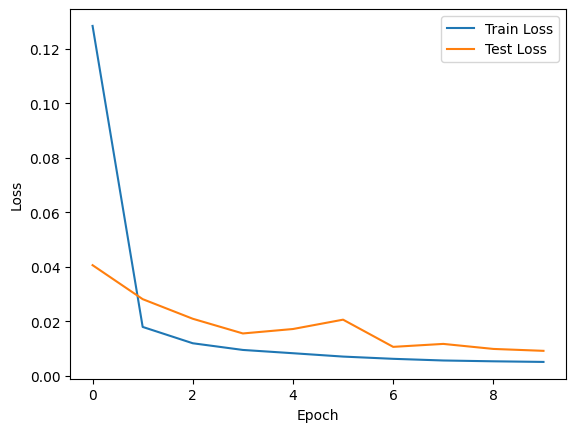

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
input_dim = 512
output_dim = 1
epochs = 100

model = LinearModel(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()


train_losses = []
test_losses = []
for epoch in range(epochs):
    train_loss, train_mae = train(train_dataloader, model, optimizer, loss_fn)
    test_loss, test_mae = eval(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if (epoch % 10 == 0) or (epoch == epochs - 1):
        print(f"Epoch {epoch}/{epochs - 1}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Epoch 0/99
Train Loss: 0.1570, Test Loss: 0.0671
Train MAE: 0.2438, Test MAE: 0.1341
Epoch 10/99
Train Loss: 0.0059, Test Loss: 0.0127
Train MAE: 0.0534, Test MAE: 0.0531
Epoch 20/99
Train Loss: 0.0026, Test Loss: 0.0057
Train MAE: 0.0357, Test MAE: 0.0354
Epoch 30/99
Train Loss: 0.0016, Test Loss: 0.0048
Train MAE: 0.0284, Test MAE: 0.0350
Epoch 40/99
Train Loss: 0.0011, Test Loss: 0.0033
Train MAE: 0.0231, Test MAE: 0.0274
Epoch 50/99
Train Loss: 0.0008, Test Loss: 0.0025
Train MAE: 0.0205, Test MAE: 0.0219
Epoch 60/99
Train Loss: 0.0007, Test Loss: 0.0018
Train MAE: 0.0186, Test MAE: 0.0180
Epoch 70/99
Train Loss: 0.0005, Test Loss: 0.0020
Train MAE: 0.0165, Test MAE: 0.0206
Epoch 80/99
Train Loss: 0.0005, Test Loss: 0.0017
Train MAE: 0.0156, Test MAE: 0.0171
Epoch 90/99
Train Loss: 0.0004, Test Loss: 0.0015
Train MAE: 0.0153, Test MAE: 0.0156
Epoch 99/99
Train Loss: 0.0004, Test Loss: 0.0018
Train MAE: 0.0152, Test MAE: 0.0200


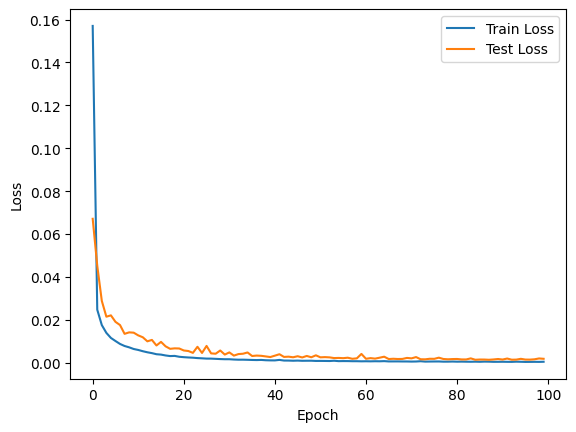

In [18]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
X_test.shape

torch.Size([26777, 32, 512])

In [24]:
samples = 128
random_samples = np.random.choice(X_test.shape[0], samples, replace=False)
X_test_samples = X_test[random_samples]
with torch.no_grad():
    preds = model(X_test_samples.to(device))
preds = preds.cpu().numpy()
y_true = y_test[random_samples].cpu().numpy()

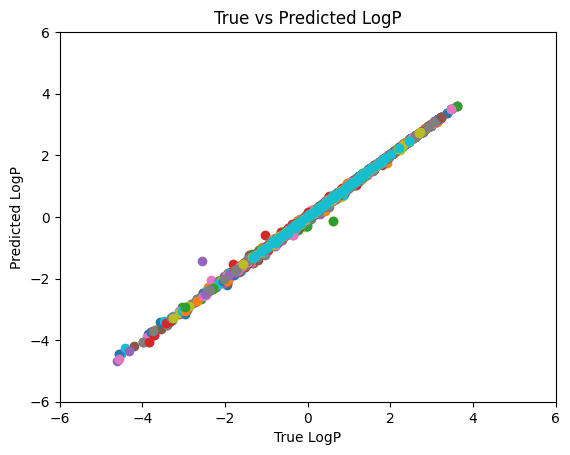

In [37]:
fig, ax = plt.subplots()
for i in range(100):
    samples = 128
    random_samples = np.random.choice(X_test.shape[0], samples, replace=False)
    X_test_samples = X_test[random_samples]
    with torch.no_grad():
        preds = model(X_test_samples.to(device))
    preds = preds.cpu().numpy()
    y_true = y_test[random_samples].cpu().numpy()
    ax.scatter(y_true, preds)
ax.set(
    xlabel='True LogP',
    ylabel='Predicted LogP',
    title='True vs Predicted LogP',
    xlim=(-6, 6),
    ylim=(-6, 6)
)
plt.show()